In [1]:
from IPython.display import display, HTML

display(HTML('''
<style>
.container { 
    width:95% !important; 
}
</style>
'''))

# Problem

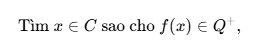

In [5]:
def f1(x):
    return 4*x[0]**2 + 4*x[1]**2
def f2(x):
    return (x[0] - 5)**2 + (x[1] - 5)**2

#--------------- C --------------------#
def c1(x):
    return (x[0] - 5)**2 + x[1]**2 - 25
def c2(x):
    return (x[0] - 8)**2 + (x[1] + 3)**2 - 7.7


#--------------- Q --------------------#
def q1(x):
    return -f1(x) + 100
def q2(x):
    return f1(x) - 200

def q3(x):
    return -f2(x) + 30
def q4(x):
    return f2(x) - 60



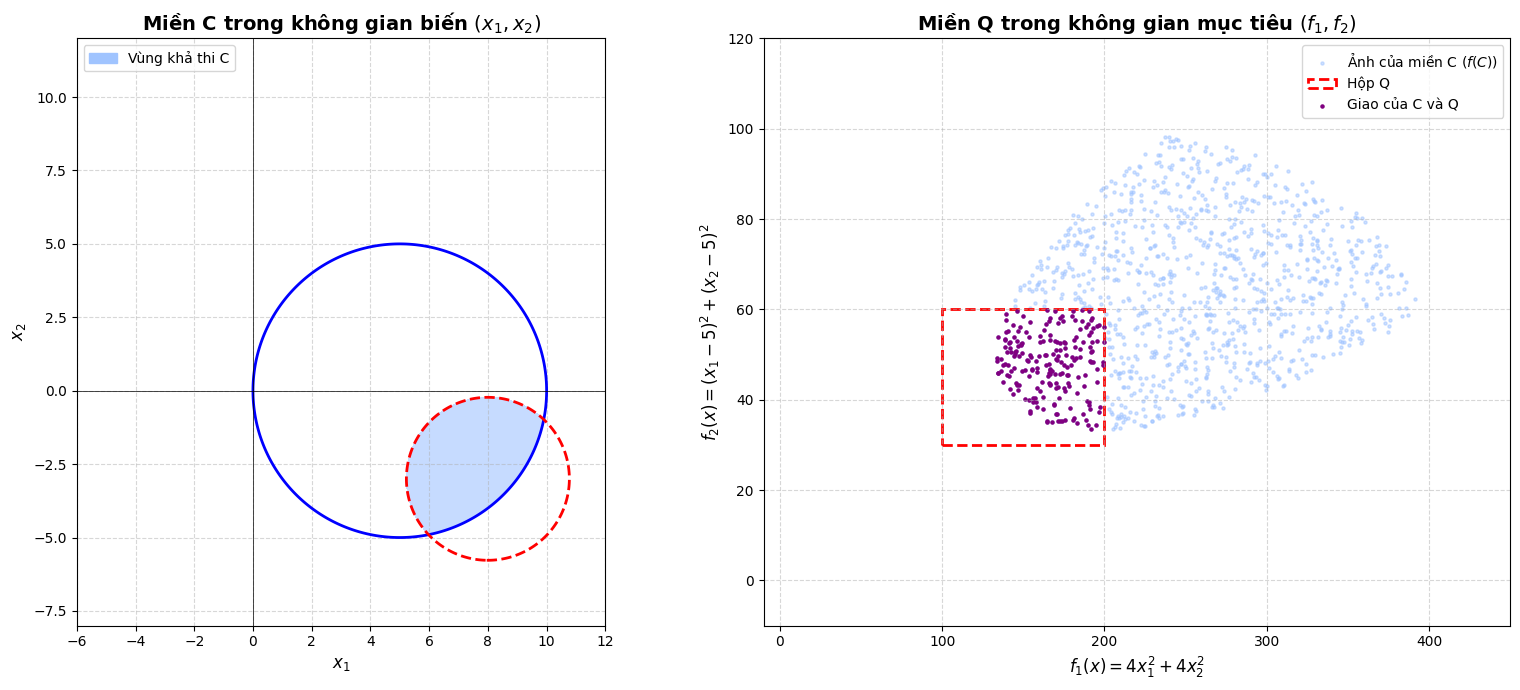

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Định nghĩa các hàm
def f1_vec(X, Y):
    return 4*X**2 + 4*Y**2

def f2_vec(X, Y):
    return (X - 5)**2 + (Y - 5)**2

# 2. Chuẩn bị dữ liệu cho PLOT 1 (Miền C trên không gian x1, x2)
x_range = np.linspace(-6, 12, 10000)
y_range = np.linspace(-8, 12, 10000)
X, Y = np.meshgrid(x_range, y_range)

# Logic miền C
val_c1 = (X - 5)**2 + Y**2 - 25
val_c2 = (X - 8)**2 + (Y + 3)**2 - 7.7
mask_C = (val_c1 <= 0) & (val_c2 <= 0)

# 3. Chuẩn bị dữ liệu cho PLOT 2 (Ánh xạ sang không gian f1, f2)
# Sinh ngẫu nhiên điểm để biểu diễn "Ảnh của miền C" lên trục f
num_samples = 30000
x_rand = np.random.uniform(-6, 12, num_samples)
y_rand = np.random.uniform(-8, 12, num_samples)

# Lọc lấy các điểm thuộc miền C
c1_rand = (x_rand - 5)**2 + y_rand**2 - 25
c2_rand = (x_rand - 8)**2 + (y_rand + 3)**2 - 7.7
mask_C_rand = (c1_rand <= 0) & (c2_rand <= 0)

x_valid = x_rand[mask_C_rand]
y_valid = y_rand[mask_C_rand]

# Tính giá trị f1, f2 tương ứng
f1_vals = f1_vec(x_valid, y_valid)
f2_vals = f2_vec(x_valid, y_valid)


# 4. Vẽ đồ thị
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ==========================================
# PLOT 1: MIỀN C (Giữ nguyên: Không gian biến x)
# ==========================================
ax1.set_title("Miền C trong không gian biến $(x_1, x_2)$", fontsize=14, fontweight='bold')
ax1.contourf(X, Y, mask_C, levels=[0.5, 1.5], colors=['#A0C4FF'], alpha=0.6)
ax1.contour(X, Y, val_c1, levels=[0], colors='blue', linewidths=2)
ax1.contour(X, Y, val_c2, levels=[0], colors='red', linestyles='dashed', linewidths=2)

ax1.set_xlabel("$x_1$", fontsize=12)
ax1.set_ylabel("$x_2$", fontsize=12)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(0, color='black', linewidth=0.5)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_aspect('equal')

# Legend cho ax1
patch_c = mpatches.Patch(color='#A0C4FF', label='Vùng khả thi C')
ax1.legend(handles=[patch_c], loc='upper left')


# ==========================================
# PLOT 2: MIỀN Q (Sửa đổi: Không gian mục tiêu f)
# ==========================================
ax2.set_title("Miền Q trong không gian mục tiêu $(f_1, f_2)$", fontsize=14, fontweight='bold')

# a. Vẽ ảnh của miền C (Scatter plot)
# Đây là tập hợp giá trị (f1, f2) mà x trong miền C tạo ra
ax2.scatter(f1_vals, f2_vals, s=5, color='#A0C4FF', alpha=0.5, label='Ảnh của miền C ($f(C)$)')

# b. Vẽ miền Q (Hình chữ nhật)
# Q: 100 <= f1 <= 200, 30 <= f2 <= 60
# Rectangle(xy, width, height)
rect_Q = mpatches.Rectangle((100, 30), 100, 30, 
                            linewidth=2, edgecolor='red', facecolor='none', 
                            linestyle='--', label='Hộp Q')
# Tô màu nhạt cho hộp Q
ax2.add_patch(rect_Q)

# c. Làm nổi bật phần giao nhau (nghiệm chấp nhận được)
mask_intersection = (f1_vals >= 100) & (f1_vals <= 200) & (f2_vals >= 30) & (f2_vals <= 60)
ax2.scatter(f1_vals[mask_intersection], f2_vals[mask_intersection], 
            s=5, color='purple', label='Giao của C và Q')

# Trang trí ax2
ax2.set_xlabel("$f_1(x) = 4x_1^2 + 4x_2^2$", fontsize=12)
ax2.set_ylabel("$f_2(x) = (x_1-5)^2 + (x_2-5)^2$", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

# Thiết lập giới hạn trục sao cho nhìn thấy cả đám mây điểm và hộp Q
ax2.set_xlim(-10, 450)
ax2.set_ylim(-10, 120)

ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Gradient approach

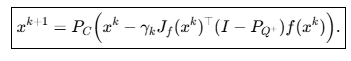

# Implement

In [34]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import BFGS
from autograd import grad
import numpy as np
from numpy import linalg as LA
from prettytable import PrettyTable
from tqdm import tqdm

In [35]:
class Problem():
    def __init__(self, f, jac_f, C, Q, proj_C, proj_Qplus):
        self.f = f
        self.jac_f = jac_f
        self.C = C
        self.Q = Q
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        return np.array([func(x) for func in self.f])
    
    def jacobian(self, x):
        return np.array([func(x) for func in self.jac_f])
            
            
        
class Projection:
    def __init__(self, cons, bounds, n, proj_type='euclid'):
        """
        cons: Ràng buộc (constraints)
        bounds: Giới hạn biên (bounds)
        n: Số chiều
        proj_type: Loại phép chiếu ('euclid' cho miền C hoặc 'qplus' cho miền Q+)
        """
        self.cons = cons
        self.bounds = bounds
        self.n = n
        self.proj_type = proj_type
        
        # Cấu hình hàm mục tiêu dựa trên loại phép chiếu
        if self.proj_type == 'qplus':
            self.objective_func = self._obj_positive_diff
        elif self.proj_type == 'euclid':
            self.objective_func = self._obj_l2_norm
        else:
            print(f"Phép chiếu {self.objective_func} không cài đặt, chọn 'qplus' hoặc 'euclid'")

    def _obj_l2_norm(self, x, y):
        """Hàm mục tiêu khoảng cách Euclid chuẩn (Dùng cho C)"""
        return np.sqrt(np.sum((x - y)**2))
    
    def _obj_positive_diff(self, x, y):
        """Hàm mục tiêu (Dùng cho Qplus)"""
        v = np.maximum(x - y, 0) 
        return np.sum(v**2)

    def project(self, target_point):
        """
        init_point: Điểm khởi tạo
        target_point: Điểm cần chiếu 
        """
        init_point = np.random.rand(1, self.n).tolist()[0]
        
        res = minimize(
            self.objective_func,
            init_point,
            args=(target_point),
            jac="2-point",
            hess=BFGS(),
            constraints=self.cons,
            method="trust-constr",
            bounds=self.bounds,
            options={'disp': False}
        )
        
        optim_point = res.x
        
        if self.proj_type == 'qplus':
            return target_point - np.maximum(target_point - optim_point, 0)
        else:
            return optim_point

In [54]:
def CQ_split_acceptance(f, jac_f, proj_C, proj_Qplus, x0,
                        gamma=1.0, max_iter=1000, tol=1e-6):
    print(f"Khởi tạo: x0: {x0[0]}")
    x = proj_C(x0)
    print(f"Chiếu lên C được: x: {x}")
    x_hist = [x.copy()]
    f_hist = [f(x).copy()]      
    z_proj_hist = []  
    table = PrettyTable()
    table.field_names = ["k", "x_new", "y", "z_proj", "e_x", "e_f"]
    
    for k in tqdm(range(max_iter)):
        z = f(x)
        z_proj = proj_Qplus(z)          # P_{Q⁺}(f(x))
        g = jac_f(x).T @ (z - z_proj)  # ∇Φ(x)
        x_new = proj_C(x - gamma * g)

        table.add_row([f"{k}", f"{x_new}", f"{z}", f"{z_proj}", f"{LA.norm(x_new - x)}", f"{LA.norm(z - z_proj)}"])
            
        if LA.norm(x - x_new) < tol:
            break
            
        x = x_new
        x_hist.append(x.copy())
        f_hist.append(f(x).copy())
        z_proj_hist.append(z_proj.copy())
    print(table)
    return x, np.array(x_hist), np.array(f_hist), np.array(z_proj_hist)

In [55]:
c1_dx = grad(c1)
c2_dx = grad(c2)

q1_dx = grad(q1)
q2_dx = grad(q2)
q3_dx = grad(q3)
q4_dx = grad(q4)

In [56]:
cons_C = (
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([-c1(x)]),     
        'jac' : lambda x: np.array([-c1_dx(x)])   
    },
    
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([-c2(x)]),     
        'jac' : lambda x: np.array([-c2_dx(x)])
    }
)

n = 2 #dim x
bounds_x = Bounds([-15,-15],[30, 30])


In [62]:
cons_Q = (
#     {
#         'type': 'ineq',
#         'fun' : lambda x: np.array([-q1(x)]),     
#         'jac' : lambda x: np.array([-q1_dx(x)])   
#     },
    
#     {
#         'type': 'ineq',
#         'fun' : lambda x: np.array([-q2(x)]),     
#         'jac' : lambda x: np.array([-q2_dx(x)])
#     },
    
#     {
#         'type': 'ineq',
#         'fun' : lambda x: np.array([-q3(x)]),     
#         'jac' : lambda x: np.array([-q3_dx(x)])   
#     },
    
#     {
#         'type': 'ineq',
#         'fun' : lambda x: np.array([-q4(x)]),     
#         'jac' : lambda x: np.array([-q4_dx(x)])
#     }
)

bounds_f = None
bounds_f =  Bounds([100,30],[200, 60])

In [63]:
proj_C = Projection(cons=cons_C, bounds=bounds_x, n=n, proj_type='euclid')

proj_Qplus = Projection(cons=cons_Q, bounds=bounds_f, n=n, proj_type='qplus')

prob = Problem(
    f=[f1, f2],
    jac_f=[grad(f1), grad(f2)],
    C=[c1, c2],
    Q=[q1, q2, q3, q4],
    proj_C=proj_C.project,
    proj_Qplus=proj_Qplus.project
    
)

In [64]:
x0 = np.random.rand(1,n).tolist()


In [65]:
x_opt, x_hist, f_hist, z_proj_hist = CQ_split_acceptance(
                                f=prob.objective_func,
                                jac_f=prob.jacobian,
                                proj_C=prob.proj_C,
                                proj_Qplus=prob.proj_Qplus,
                                x0=x0,
                                gamma=0.01,
                                max_iter=50,
                                tol=1e-6
                            )

Khởi tạo: x0: [0.6771243298909119, 0.05468240178871353]
Chiếu lên C được: x: [ 5.43899832 -1.93169744]


 48%|████▊     | 24/50 [00:02<00:02, 10.31it/s]

+----+---------------------------+-----------------------------+-----------------------------+------------------------+--------------------+
| k  |           x_new           |              y              |            z_proj           |          e_x           |        e_f         |
+----+---------------------------+-----------------------------+-----------------------------+------------------------+--------------------+
| 0  | [ 5.52619944 -1.7428959 ] | [133.25663107  48.24114899] | [100.00001457  30.00140567] |  0.20796648563265102   | 37.93007747359056  |
| 1  | [ 5.4775711  -1.84356046] | [134.30626537  45.74353093] | [100.00001466  30.00132369] |  0.11179476645433709   | 37.74567427841594  |
| 2  | [ 5.50343728 -1.7887302 ] | [133.61000148  47.06239397] | [100.00001467  30.00124852] |  0.060625220960260406  | 37.69235860516026  |
| 3  | [ 5.48931863 -1.81827288] | [133.94951053  46.34030677] | [100.0000147   30.00123747] |  0.032743035950559225  | 37.676696406260135 |
| 4  | [ 5.49

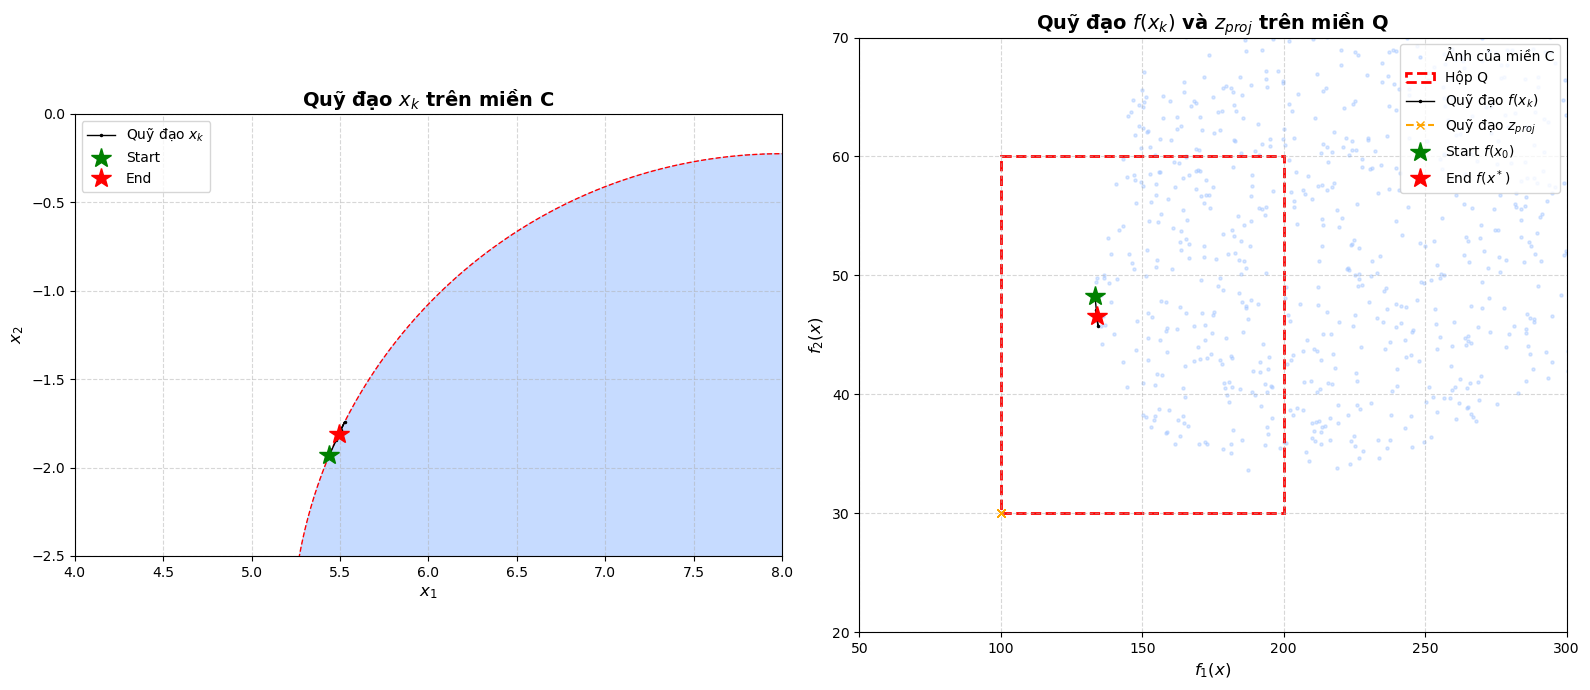

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ... (Phần chuẩn bị dữ liệu f1_vec, f2_vec, mask_C, random sample... giữ nguyên) ...
# (Giả định bạn đã có sẵn các biến x_hist, f_hist, z_proj_hist từ thuật toán chạy trước đó)

# --- Bắt đầu vẽ ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ---------------- PLOT 1: KHÔNG GIAN BIẾN (x1, x2) ----------------
ax1.set_title("Quỹ đạo $x_k$ trên miền C", fontsize=14, fontweight='bold')
ax1.contourf(X, Y, mask_C, levels=[0.5, 1.5], colors=['#A0C4FF'], alpha=0.6)
ax1.contour(X, Y, val_c1, levels=[0], colors='blue', linewidths=1)
ax1.contour(X, Y, val_c2, levels=[0], colors='red', linestyles='dashed', linewidths=1)

ax1.plot(x_hist[:,0], x_hist[:,1], 'k.-', linewidth=1, markersize=3, label='Quỹ đạo $x_k$')
ax1.plot(x_hist[0,0], x_hist[0,1], 'g*', markersize=15, label='Start') 
ax1.plot(x_hist[-1,0], x_hist[-1,1], 'r*', markersize=15, label='End') 

ax1.set_xlabel("$x_1$", fontsize=12)
ax1.set_ylabel("$x_2$", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_aspect('equal')
ax1.legend(loc='upper left')

# ---------------- PLOT 2: KHÔNG GIAN MỤC TIÊU (f1, f2) ----------------
ax2.set_title("Quỹ đạo $f(x_k)$ và $z_{proj}$ trên miền Q", fontsize=14, fontweight='bold')

# Nền: Ảnh của C
ax2.scatter(f1_vals, f2_vals, s=5, color='#A0C4FF', alpha=0.4, label='Ảnh của miền C')

# Nền: Hộp Q
rect_Q = mpatches.Rectangle((100, 30), 100, 30, 
                            linewidth=2, edgecolor='red', facecolor='none', 
                            linestyle='--', label='Hộp Q')

ax2.add_patch(rect_Q)

# >>> VẼ QUỸ ĐẠO f(x) <<<
ax2.plot(f_hist[:,0], f_hist[:,1], 'k.-', linewidth=1, markersize=3, label='Quỹ đạo $f(x_k)$')

# >>> SỬA ĐỔI TẠI ĐÂY: VẼ QUỸ ĐẠO z_proj CÓ ĐƯỜNG NỐI <<<
# Thay vì dùng scatter, ta dùng plot với linestyle='--' (nét đứt) hoặc '-' (nét liền)
ax2.plot(z_proj_hist[:,0], z_proj_hist[:,1], 
         color='orange',      # Màu cam
         linestyle='--',      # Nét đứt để phân biệt với f(x)
         linewidth=1.5,       # Độ dày nét
         marker='x',          # Đánh dấu điểm bằng dấu x
         markersize=6,        # Kích thước dấu x
         label='Quỹ đạo $z_{proj}$')

# Điểm đầu và cuối của f(x)
ax2.plot(f_hist[0,0], f_hist[0,1], 'g*', markersize=15, label='Start $f(x_0)$')
ax2.plot(f_hist[-1,0], f_hist[-1,1], 'r*', markersize=15, label='End $f(x^*)$')

ax2.set_xlabel("$f_1(x)$", fontsize=12)
ax2.set_ylabel("$f_2(x)$", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_xlim(50, 300) 
ax2.set_ylim(20, 70)
ax2.legend(loc='upper right')

ax1.set_xlim(4, 8)
ax1.set_ylim(-2.5, 0)

plt.tight_layout()
plt.show()

# Vẽ lại luồng thuật toán

<font size=5>Tìm $x\in C$ sao cho $\exists y \in Q$ thỏa mãn $f(x) \leq y \quad(1)$ 

trong đó: 
* $C, Q$ là tập lồi, đóng
* $f$ là ánh xạ lồi

---

Định nghĩa: 

<font size=4> $Q^+ = \{z \in R^m | \exists y \in Q, z \leq y\}$

Khi đó:

<font size=4> $ (1) \Leftrightarrow $ Tìm $x \in C$ sao cho $f(x) \in Q^+$

---

Hàm khoảng cách:

$ \Phi(x) := \frac{1}{2} \rVert f(x) - P_{Q^+}(f(x)\rVert^2  $

Mục tiêu: đưa $f(x)$ về gần với hình chiếu của nó trên tập $Q^+$ nhất

* $\Phi(x) = 0 \rightarrow x$ là nghiệm chấp nhận tách
* $\Phi(x) \neq 0 \rightarrow $ chuyển về bài toán xấp xỉ tốt nhất

---


<font size=5> $\nabla \Phi (x) = J_f(x)^T (I - P_{Q^+})f(x)$

Công thức cập nhật $x^k$

<font size=5> $\Rightarrow x^{k+1} = P_C(x^k - \gamma_k \nabla\Phi(x^k))$ 

---

$P_C(\tilde x) = \text{Argmin}_{x \in C} \rVert x - \tilde x \rVert ^2$

---

$y^* = \text{Argmin}_{y \in Q} \rVert (y - \tilde z )_+\rVert ^2$

$P_{Q^+}(\tilde z) = \text{min}(\tilde z, y^*) = \tilde z - (\tilde z - y^*)_+$